In [11]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.covariance import EllipticEnvelope

from src.features import utils, build_features_final, build_features
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.visualization.visual import anomaly_plot
from src.config.config import seed_everything, cfg

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

train_data = pd.read_csv(r'data\raw\train_data.csv')
add_train = pd.read_csv(r'data\processed\robust.csv')
# train_data = utils.outlier_z_score_filter_df(train_data, threshold=3)
train_data = pd.concat([train_data, add_train], axis=0)
train_data = build_features_final.create_derived_features(train_data)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features_final.create_derived_features(test_data)


grouped_train = train_data.groupby('type')

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", 'volumetric_efficiency',
                'air_to_motor_ratio']


anomaly = []
all_threshold = []
for group_name, group_data in grouped_train:
    test_group = test_data[test_data['type'] == group_name]
    train_group = group_data.drop(drop_feature, axis=1).values
    test_group = test_group.drop(drop_feature, axis=1).values

    train_group = scaler.fit_transform(train_group)
    test_group = scaler.transform(test_group)
    
    envelope = EllipticEnvelope(support_fraction = 1, contamination = 0.005, random_state = 1103)
    envelope.fit(train_group)
    pred = np.where(envelope.predict(test_group) == -1, 1, 0)
    
    anomaly.append(pred)
    print(f"finish {group_name}type")

anomaly = np.concatenate(anomaly)
submission = prediction_to_csv(anomaly)

finish 0type
finish 1type
finish 2type
finish 3type
finish 4type
finish 5type
finish 6type
finish 7type
0    6989
1     400
Name: label, dtype: int64


In [12]:
test_data['label'] = anomaly
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no
yes, no = no_out(test_data)

Chunk 0: 152/1296 labels with value 1


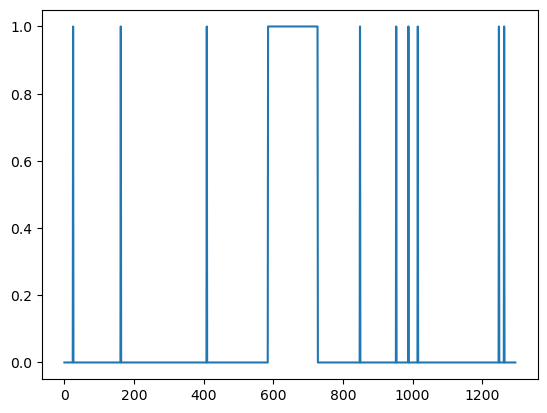

Chunk 1: 0/1107 labels with value 1


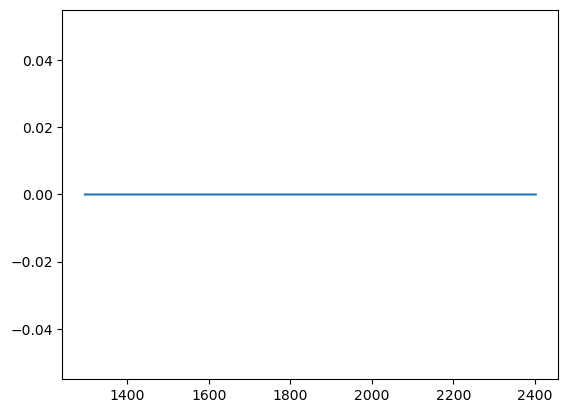

Chunk 2: 38/1098 labels with value 1


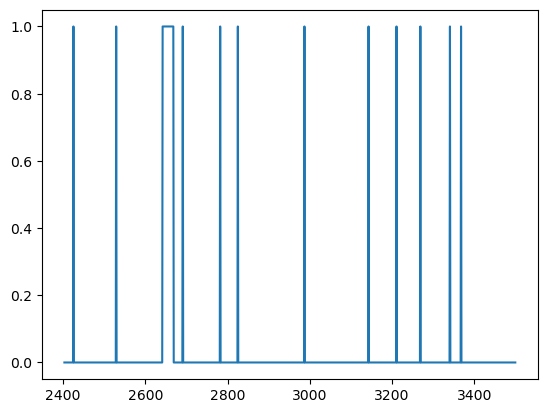

Chunk 3: 44/918 labels with value 1


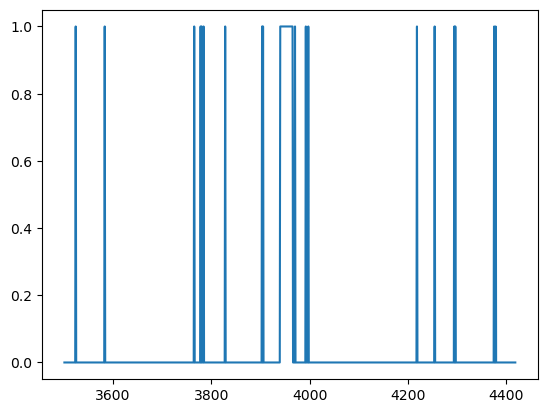

Chunk 4: 21/918 labels with value 1


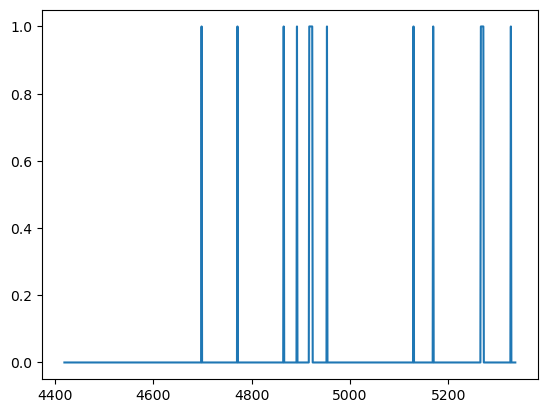

Chunk 5: 33/746 labels with value 1


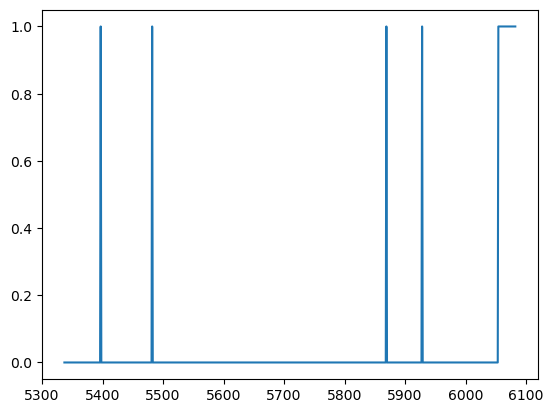

Chunk 6: 105/748 labels with value 1


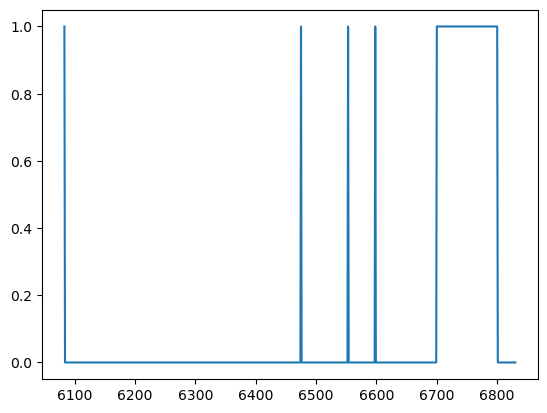

Chunk 7: 7/558 labels with value 1


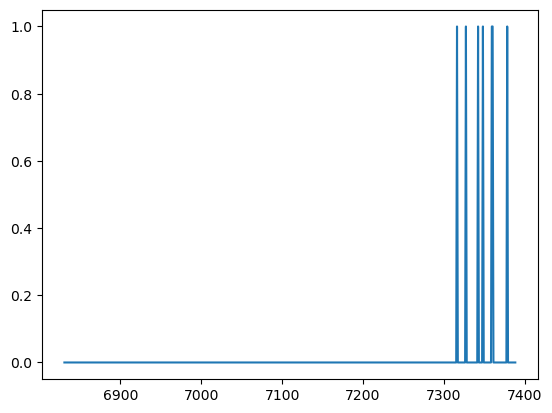

In [13]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels}/{len(chunk)} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(anomaly))]
plot_label_counts(submission, ranges)